In [1]:
# final timestep =  15724
from firedrake import *
from gadopt import *
import numpy as np

#set up mesh
rmin, rmax, ncells, nlayers = 1.22, 2.22, 256, 64
bottom_id, top_id = "bottom", "top"

with CheckpointFile("final_checkpoint_1e5_mu_t.h5", 'r') as final_checkpoint:
    mesh = final_checkpoint.load_mesh("firedrake_default_extruded")
    mesh.cartesian = False
    
    T = final_checkpoint.load_function(mesh, "Temperature", idx = 15724)
    mu = final_checkpoint.load_function(mesh, "Viscosity", idx = 15724)
    Taverage = final_checkpoint.load_function(mesh, "Average Temperature", idx =0)

#solving for the Dynamic Topography (DT1)

V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Q1 = FunctionSpace(mesh, "CG", 1)  # Average pressure function space (scalar, P1)
Q2 = FunctionSpace(mesh, "CG", 2) #Dynamic Topogrpahy function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.

# Paverage = Function(Q1, name="Average Pressure")
# # Calculate the layer average of the initial state
# averager_pressure = LayerAveraging(mesh, np.linspace(rmin, rmax, nlayers * 2), quad_degree=6)
# averager_pressure.extrapolate_layer_average(Paverage, averager_pressure.get_layer_average(p_load))

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p

#velocity and pressure functions
u_func, p_func = z.subfunctions
u_func.rename("Velocity")
p_func.rename("Pressure")

Ra = Constant(1e5)  # Rayleigh number
approximation = BoussinesqApproximation(Ra)

Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=True)

Z_near_nullspace = create_stokes_nullspace(Z, closed=False, rotational=True, translations=[0, 1])

#bcs 
stokes_bcs = {
    bottom_id: {'un': 0},
    top_id: {'un': 0},
}

temp_bcs = {
    bottom_id: {'T': 1.0},
    top_id: {'T': 0.0},
}

stokes_solver = StokesSolver(z, T, approximation, bcs=stokes_bcs, mu=mu,
                            constant_jacobian=True,
                             nullspace=Z_nullspace, transpose_nullspace=Z_nullspace,
                             near_nullspace=Z_near_nullspace)

surface_force_solver = BoundaryNormalStressSolver(stokes_solver, top_id)

# At this point we have all the solver objects we need, we first solve for
# velocity, and then surface force (or surface dynamic topography)

# Solve Stokes sytem:
stokes_solver.solve()

#get the stresses
surface_force = surface_force_solver.solve()

#dynamic topography
deltarho_g = Constant(1e3) #delta rho = 100, g = 10
dt_actual = Function(Q2, name="Actual DT")
dt_actual.interpolate((surface_force / deltarho_g))

# And here we visualise it and write the fields out

VTKFile("dt_actual_mu_t.pvd").write(*z.subfunctions, T, dt_actual, mu)
with CheckpointFile("dt_actual_mu_t.h5", mode="w") as file:
    file.save_mesh(mesh)
    file.save_function(dt_actual, name="Actual DT")
    file.save_function(T, name="Temperature")
    file.save_function(mu, name="Viscosity")


/Users/prahlada/firedrake/lib/python3.12/site-packages/pytools/persistent_dict.py:59: UserWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 5
  1 SNES Function norm 5.956756035353e-02


/Users/prahlada/firedrake/src/firedrake/firedrake/constant.py:73: FutureWarning: Giving Constants a domain is no longer supported. Instead please create a Function in the Real space.
  warnings.warn(


In [8]:
#DT2 (wrong viscosity)
#solving for the Dynamic Topography (DT2)

from gadopt import *
from gadopt.inverse import *

#load previous stuff - mesh, T, DT1
bottom_id, top_id = "bottom", "top"
with CheckpointFile("dt_actual_mu_t.h5", 'r') as final_checkpoint:
    mesh = final_checkpoint.load_mesh("firedrake_default_extruded")
    mesh.cartesian = False
    
    #viscosity as control
    T = final_checkpoint.load_function(mesh, "Temperature")
    dt_actual = final_checkpoint.load_function(mesh, "Actual DT")
    mu_actual = final_checkpoint.load_function(mesh, "Viscosity")

V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Q2 = FunctionSpace(mesh, "CG", 2) #Dynamic Topogrpahy function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

Ra = Constant(1e5)  # Rayleigh number
approximation = BoussinesqApproximation(Ra)

#viscosity as control d(mu)
mu_control = Function(W, name="control").assign(0.0)
control = Control(mu_control)

#viscosity (isoviscous)
mu_iso = Function(W, name="Isoviscosity")
mu_iso.interpolate(10 ** (mu_control))

Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=True)

Z_near_nullspace = create_stokes_nullspace(Z, closed=False, rotational=True, translations=[0, 1])

#bcs 
stokes_bcs = {
    bottom_id: {'un': 0},
    top_id: {'un': 0},
}

temp_bcs = {
    bottom_id: {'T': 1.0},
    top_id: {'T': 0.0},
}

stokes_solver = StokesSolver(z, T, approximation, bcs=stokes_bcs, mu=mu_iso,
                            constant_jacobian=True,
                             nullspace=Z_nullspace, transpose_nullspace=Z_nullspace,
                             near_nullspace=Z_near_nullspace)

surface_force_solver = BoundaryNormalStressSolver(stokes_solver, top_id)

# At this point we have all the solver objects we need, we first solve for
# velocity, and then surface force (or surface dynamic topography)

# Solve Stokes sytem:
stokes_solver.solve()

#surface stress
surface_force = surface_force_solver.solve()

#isoviscous DT
deltarho_g = Constant(1e3) #delta rho = 100, g = 10
dt_iso = Function(Q2, name="Isoviscous DT")
dt_iso.interpolate((surface_force / deltarho_g))

#store the data till now
with CheckpointFile("DT_file_mu_t.h5", mode="w") as file:
    file.save_mesh(mesh)
    file.save_function(dt_actual, name="DT_actual")
    file.save_function(dt_iso, name="DT_isoviscous")
    file.save_function(T, name="Temperature")
    file.save_function(mu_iso, name="Isoviscosity")
    file.save_function(mu_actual, name="Viscosity")


#cost function calculation (J)
objective_func = assemble(0.5 * (dt_actual - dt_iso) ** 2 * ds_t)   #J (Cost function)
print ("cost function = ", objective_func)

#reduced functional (adjoints)
reduced_functional = ReducedFunctional(objective_func, controls=control)  #dJ/d(mu)
print ("dJ/d(mu) ", reduced_functional)

#Calculate the gradient and see sensitivity
grad_func = reduced_functional.derivative(options={"riesz_representation": "L2"}) #see gradient
grad_func.rename("gradient func")

#visualisations 
VTKFile("gradient_mu_t.pvd").write(T, mu_iso, mu_actual, dt_iso, dt_actual, grad_func)


  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 3.113304080369e-02
cost function =  2.518312679174424
dJ/d(mu)  <pyadjoint.reduced_functional.ReducedFunctional object at 0x166146120>


/Users/prahlada/firedrake/src/firedrake/firedrake/constant.py:73: FutureWarning: Giving Constants a domain is no longer supported. Instead please create a Function in the Real space.
  warnings.warn(
/Users/prahlada/firedrake/src/firedrake/firedrake/adjoint_utils/function.py:112: UserWarning: Could not find overloaded class of type '<class 'int'>'.
  other = create_overloaded_object(other)


    Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3


In [9]:
# Performing taylor test
Delta_mu = Function(mu_iso.function_space(), name="Delta_Temperature")
Delta_mu.dat.data[:] = np.random.random(Delta_mu.dat.data.shape)

# Perform the Taylor test to verify the gradients
minconv = taylor_test(reduced_functional, mu_iso, Delta_mu)

  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 3.113304080369e-02
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 3.051916403311e-02
    Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
Running Taylor test
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 3.113304080369e-02
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 2.808780089123e-02
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 3.113304080369e-02
  0 SNES Function norm 2.020175347423e+03
      Line

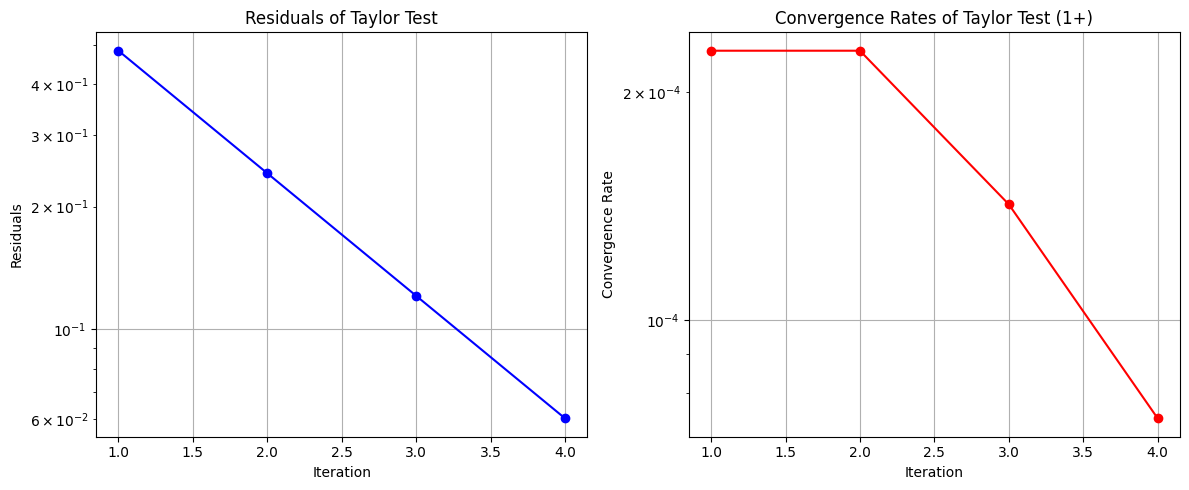

In [26]:
import matplotlib.pyplot as plt

residuals = [0.4832989750400654, 0.2416114762461853, 0.12079383795786187, 0.06039381874518188]
convergence_rates = [.0002269526425775, .0002269526425775, .0001421220157467, .0000740568679456]

iterations = range(1, len(residuals) + 1)

# residual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(iterations, residuals, marker='o', linestyle='-', color='b')
plt.yscale('log')  # Log scale for better visualization
plt.xlabel('Iteration')
plt.ylabel('Residuals')
plt.title('Residuals of Taylor Test')
plt.grid(True)

# convergence rate
plt.subplot(1, 2, 2)
plt.plot(iterations, convergence_rates, marker='o', linestyle='-', color='r')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence Rate')
plt.title('Convergence Rates of Taylor Test (1+)')
plt.grid(True)

plt.tight_layout()
plt.show()


smoother solver

In [20]:
#DT2 (wrong viscosity)
#solving for the Dynamic Topography (DT2)

from gadopt import *
from gadopt.inverse import *

#load previous stuff - mesh, T, DT1
bottom_id, top_id = "bottom", "top"
with CheckpointFile("dt_actual_mu_t.h5", 'r') as final_checkpoint:
    mesh = final_checkpoint.load_mesh("firedrake_default_extruded")
    mesh.cartesian = False
    
    #viscosity as control
    T = final_checkpoint.load_function(mesh, "Temperature")
    dt_actual = final_checkpoint.load_function(mesh, "Actual DT")
    mu_actual = final_checkpoint.load_function(mesh, "Viscosity")

V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Q2 = FunctionSpace(mesh, "CG", 2) #Dynamic Topogrpahy function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

Ra = Constant(1e5)  # Rayleigh number
approximation = BoussinesqApproximation(Ra)


#Smoothing 
er = as_vector((1, 0))  # Radial 
etheta = as_vector((0, 1))  # Angular 

kr = 1.0  # radial 
ktheta = 0.0  # angular 

# Conductivity  
K = kr * outer(er, er) + ktheta * outer(etheta, etheta)

smoother = DiffusiveSmoothingSolver(function_space=W, wavelength=1.0, K=K)

#viscosity as control d(mu)
mu_control = Function(W, name="control").assign(0.0)
control = Control(mu_control)

#viscosity (isoviscous)
mu_iso = Function(W, name="Isoviscosity")
mu_iso.interpolate(10 ** smoother.action(mu_control))

Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=True)

Z_near_nullspace = create_stokes_nullspace(Z, closed=False, rotational=True, translations=[0, 1])

#bcs 
stokes_bcs = {
    bottom_id: {'un': 0},
    top_id: {'un': 0},
}

temp_bcs = {
    bottom_id: {'T': 1.0},
    top_id: {'T': 0.0},
}

stokes_solver = StokesSolver(z, T, approximation, bcs=stokes_bcs, mu=mu_iso,
                            constant_jacobian=True,
                             nullspace=Z_nullspace, transpose_nullspace=Z_nullspace,
                             near_nullspace=Z_near_nullspace)

surface_force_solver = BoundaryNormalStressSolver(stokes_solver, top_id)

# At this point we have all the solver objects we need, we first solve for
# velocity, and then surface force (or surface dynamic topography)

# Solve Stokes sytem:
stokes_solver.solve()

#surface stress
surface_force = surface_force_solver.solve()

#isoviscous DT
deltarho_g = Constant(1e3) #delta rho = 100, g = 10
dt_iso = Function(Q2, name="Isoviscous DT")
dt_iso.interpolate((surface_force / deltarho_g))

#store the data till now
with CheckpointFile("DT_file_mu_t_smoothing.h5", mode="w") as file:
    file.save_mesh(mesh)
    file.save_function(dt_actual, name="DT_actual")
    file.save_function(dt_iso, name="DT_isoviscous")
    file.save_function(T, name="Temperature")
    file.save_function(mu_iso, name="Isoviscosity")
    file.save_function(mu_actual, name="Viscosity")


#cost function calculation (J)
objective_func = assemble(0.5 * (dt_actual - dt_iso) ** 2 * ds_t)   #J (Cost function)
print ("cost function = ", objective_func)

#reduced functional (adjoints)
reduced_functional = ReducedFunctional(objective_func, controls=control)  #dJ/d(mu)
print ("dJ/d(mu) ", reduced_functional)

#Calculate the gradient and see sensitivity
grad_func = reduced_functional.derivative(options={"riesz_representation": "L2"}) #see gradient
grad_func.rename("gradient func")

#visualisations 
VTKFile("gradient_mu_t_smoothing.pvd").write(T, mu_iso, mu_actual, dt_iso, dt_actual, grad_func)


# Performing taylor test
Delta_mu = Function(mu_iso.function_space(), name="Delta_Temperature")
Delta_mu.dat.data[:] = np.random.random(Delta_mu.dat.data.shape)

# Perform the Taylor test to verify the gradients
minconv = taylor_test(reduced_functional, mu_iso, Delta_mu)



  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 3.113304080369e-02
cost function =  2.518312679174424
dJ/d(mu)  <pyadjoint.reduced_functional.ReducedFunctional object at 0x176d5be00>


/Users/prahlada/firedrake/src/firedrake/firedrake/constant.py:73: FutureWarning: Giving Constants a domain is no longer supported. Instead please create a Function in the Real space.
  warnings.warn(
/Users/prahlada/firedrake/src/firedrake/firedrake/adjoint_utils/function.py:112: UserWarning: Could not find overloaded class of type '<class 'int'>'.
  other = create_overloaded_object(other)


    Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 3.113304080369e-02
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 4.112316077136e-02
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 3.051916403344e-02
    Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
Running Taylor test
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 3.113304080369e-02
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Fu

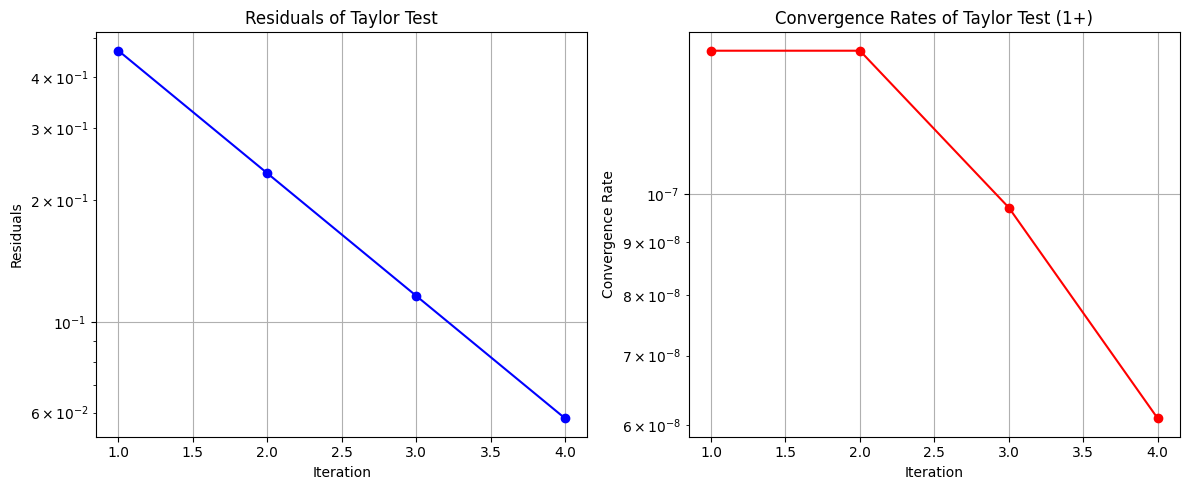

In [25]:
import matplotlib.pyplot as plt

residuals = [0.4647952088213338, 0.23239758226254756, 0.1161987833071864, 0.05809938920053256]
convergence_rates = [np.float64(.0000001374927403), np.float64(.0000001374927403), np.float64(.0000000971419094), np.float64(.0000000609131765)]

iterations = range(1, len(residuals) + 1)

# residual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(iterations, residuals, marker='o', linestyle='-', color='b')
plt.yscale('log')  # Log scale for better visualization
plt.xlabel('Iteration')
plt.ylabel('Residuals')
plt.title('Residuals of Taylor Test')
plt.grid(True)

# convergence rate
plt.subplot(1, 2, 2)
plt.plot(iterations, convergence_rates, marker='o', linestyle='-', color='r')
plt.yscale('log')  # Log scale for better visualization
plt.xlabel('Iteration')
plt.ylabel('Convergence Rate')
plt.title('Convergence Rates of Taylor Test (1+)')
plt.grid(True)

plt.tight_layout()
plt.show()


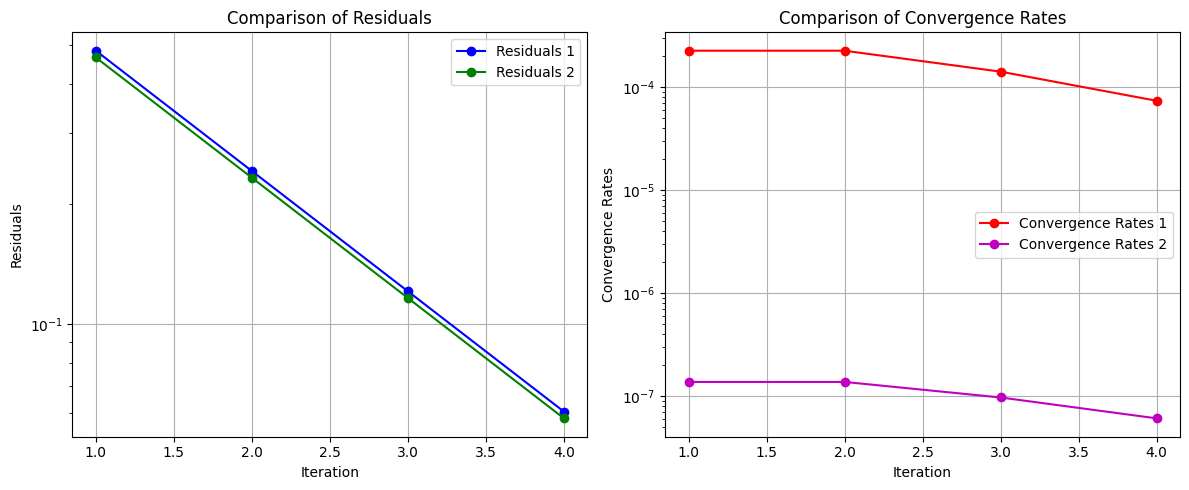

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data for first plot
residuals_1 = [0.4832989750400654, 0.2416114762461853, 0.12079383795786187, 0.06039381874518188]
convergence_rates_1 = [.0002269526425775, .0002269526425775, .0001421220157467, .0000740568679456]

# Data for second plot
residuals_2 = [0.4647952088213338, 0.23239758226254756, 0.1161987833071864, 0.05809938920053256]
convergence_rates_2 = [np.float64(.0000001374927403), np.float64(.0000001374927403), np.float64(.0000000971419094), np.float64(.0000000609131765)]

iterations = range(1, len(residuals_1) + 1)

# Create the plot
plt.figure(figsize=(12, 5))

# Plot residuals comparison
plt.subplot(1, 2, 1)
plt.plot(iterations, residuals_1, marker='o', linestyle='-', color='b', label='Residuals 1')
plt.plot(iterations, residuals_2, marker='o', linestyle='-', color='g', label='Residuals 2')
plt.yscale('log')  # Log scale for better visualization
plt.xlabel('Iteration')
plt.ylabel('Residuals')
plt.title('Comparison of Residuals')
plt.legend()
plt.grid(True)

# Plot convergence rates comparison
plt.subplot(1, 2, 2)
plt.plot(iterations, convergence_rates_1, marker='o', linestyle='-', color='r', label='Convergence Rates 1')
plt.plot(iterations, convergence_rates_2, marker='o', linestyle='-', color='m', label='Convergence Rates 2')
plt.yscale('log')  # Log scale for better visualization
plt.xlabel('Iteration')
plt.ylabel('Convergence Rates')
plt.title('Comparison of Convergence Rates')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [38]:
#optimisation

In [41]:
# Callback function for writing out the solution's visualisation
optimiser_pvd = VTKFile("optimiser.pvd")
def callback():
    optimiser_pvd.write(mu_control.block_variable.checkpoint)
    

# Perform a bounded nonlinear optimisation 
mu_lb = Function(mu_control.function_space(), name="Lower bound temperature")
mu_ub = Function(mu_control.function_space(), name="Upper bound temperature")
mu_lb.assign(0.4)
mu_ub.assign(2.0)

minimisation_problem = MinimizationProblem(reduced_functional, bounds=(mu_lb, mu_ub))

# Adjust minimisation parameters
minimisation_parameters["Status Test"]={
        "Gradient Tolerance": 1e-4,
        "Iteration Limit": 2,
    }

optimiser = LinMoreOptimiser(
    minimisation_problem,
    minimisation_parameters,
    checkpoint_dir="optimisation_checkpoint"
)

optimiser.add_callback(callback)
optimiser.run()

  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 3.113304080369e-02
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve converged due to CONVERGED_RTOL iterations 3
  1 SNES Function norm 4.112316077136e-02
  0 SNES Function norm 2.020175347423e+03
      Linear Stokes_fieldsplit_1_ solve did not converge due to DIVERGED_NANORINF iterations 0


ConvergenceError: Nonlinear solve failed to converge after 0 nonlinear iterations.
Reason:
   DIVERGED_LINEAR_SOLVE